In [20]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns
import pandas as pd

from copy import deepcopy
from corner import corner

from taurex.binning.fluxbinner import FluxBinner
from taurex.util.util import wnwidth_to_wlwidth

WDIR = Path().cwd().parent


In [19]:
def get_target_results(path=None):
    if path is None:
        path = Path(WDIR / "data/synthetic_spectra/WASP-39b")

    path = Path(path)

    paths = Path(path).rglob("*_output.hdf5")
    paths = list(paths)
    results = [""] * len(paths)

    for i, res in enumerate(paths):
        results[i] = h5py.File(res)

    for i, res in enumerate(results):
        try:
            __ = res['Observed']
            __ = res['Output']['Solutions']
        except KeyError:
            print(f"{paths[i].name} does not have Observed or Solutions")

    return results


results = get_target_results()

C:\Users\lukas\Documents\git\compla\data\synthetic_spectra\WASP-39b
[WindowsPath('C:/Users/lukas/Documents/git/compla/data/synthetic_spectra/WASP-39b/2023-04-26-10-25-19_output.hdf5'), WindowsPath('C:/Users/lukas/Documents/git/compla/data/synthetic_spectra/WASP-39b/WASP-39b_HST_STIS_G430L_52X2_Sing+2016,TM1_time-2023-04-26-10-25-19_output.hdf5'), WindowsPath('C:/Users/lukas/Documents/git/compla/data/synthetic_spectra/WASP-39b/WASP-39b_HST_WFC3_G141_GRISM256_Wakeford+2018,TM0_time-2023-04-26-10-25-19_output.hdf5')]
C:\Users\lukas\Documents\git\compla\data\synthetic_spectra\WASP-39b\2023-04-26-10-25-19_output.hdf5
C:\Users\lukas\Documents\git\compla\data\synthetic_spectra\WASP-39b\WASP-39b_HST_STIS_G430L_52X2_Sing+2016,TM1_time-2023-04-26-10-25-19_output.hdf5
C:\Users\lukas\Documents\git\compla\data\synthetic_spectra\WASP-39b\WASP-39b_HST_WFC3_G141_GRISM256_Wakeford+2018,TM0_time-2023-04-26-10-25-19_output.hdf5


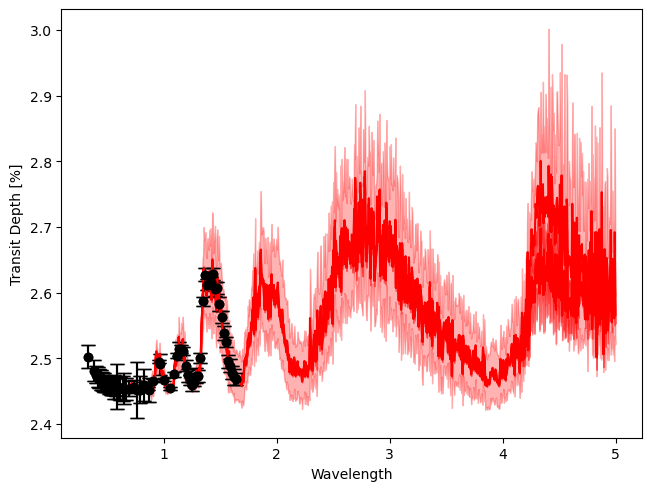

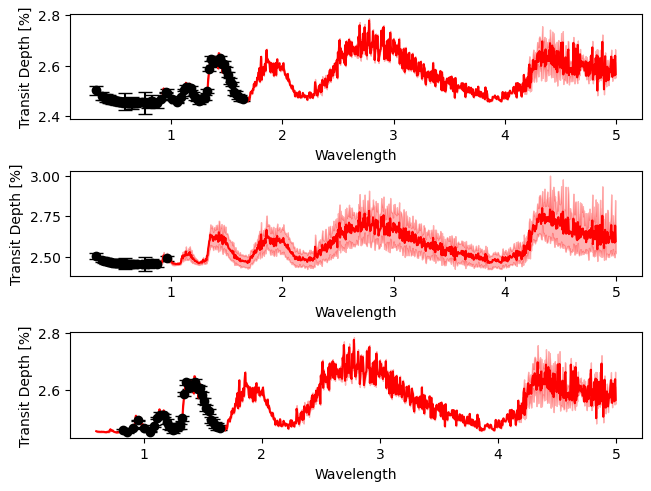

In [27]:
def bin_spectrum(low_res, high_res):
    transmission_spectra = high_res.sort_values(by='wavelength')
    low_res = low_res.sort_values(by='wavelength')
    low_res = low_res.reset_index(drop=True)

    binner = FluxBinner(low_res['wavelength'].values)

    _, binned_transit_depth, _, _ = binner.bindown(transmission_spectra['wavelength'].values,
                                                   transmission_spectra['depth'].values)

    return np.array(binned_transit_depth)


def plot_spectrum_into_ax(hdf5file=None, outfile=None, ax=None):
    if hdf5file is None:
        pass
    if outfile is None:
        pass

    if ax is None:
        ax = plt.gca()

    if isinstance(hdf5file, (str, Path)):
        res = h5py.File(hdf5file, 'r')
    elif isinstance(hdf5file, h5py.File):
        res = hdf5file
    else:
        raise NotImplementedError

    res_spec = res['Output']['Solutions']['solution0']['Spectra']
    factor = 1e2

    hr = pd.DataFrame(res_spec['native_wlgrid'][()], columns=['wavelength'])
    hr['depth'] = res_spec['native_spectrum'][()]

    bd = 0.005
    lr = pd.DataFrame(np.arange(0.6, 5, bd), columns=['wavelength'])
    lr['depth'] = bin_spectrum(lr.copy(), hr)

    hr_plus_std = hr.copy()
    hr_plus_std['depth'] = res_spec['native_spectrum'][()] + res_spec['native_std'][()]

    hr_minus_std = hr.copy()
    hr_minus_std['depth'] = res_spec['native_spectrum'][()] - res_spec['native_std'][()]

    lr['depth_m_std'] = bin_spectrum(lr.copy(), hr_minus_std)
    lr['depth_p_std'] = bin_spectrum(lr.copy(), hr_plus_std)

    try:
        ax.errorbar(res['Observed']['wlgrid'][()], res['Observed']['spectrum'][()] * factor,
                    yerr=res['Observed']['errorbars'][()] * factor,
                    fmt='o', c='k', capsize=5)
    except KeyError:
        pass
    ax.plot(lr['wavelength'], lr['depth'] * factor, c='r')
    ax.fill_between(lr['wavelength'], lr['depth_m_std'] * factor, lr['depth_p_std'] * factor, color='r', alpha=0.3)
    # ax.set_xlim(0.85, 1.7)
    # ax.set_ylim(2.01, 2.17)
    ax.set_xlabel('Wavelength')
    ax.set_ylabel('Transit Depth [%]')
    return ax


fig, ax = plt.subplots(1, 1, num="spectrum_differences", constrained_layout=True)

for i, file in enumerate(results):
    ax = plot_spectrum_into_ax(file)

# filename = Path(model_files[0]).parent / "spectrum_differences.png"
# plt.savefig(filename, dpi=300)

fig, axes = plt.subplots(len(results), 1, num="stacked_spectrum_differences", constrained_layout=True)

axes = np.array(axes).flatten()

for i, (file, ax) in enumerate(zip(results, axes)):
    plt.sca(ax)
    ax = plot_spectrum_into_ax(file)

(3916, 5)


C:\Users\lukas\AppData\Local\Temp\ipykernel_14368\4036074652.py:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('gist_rainbow', n)


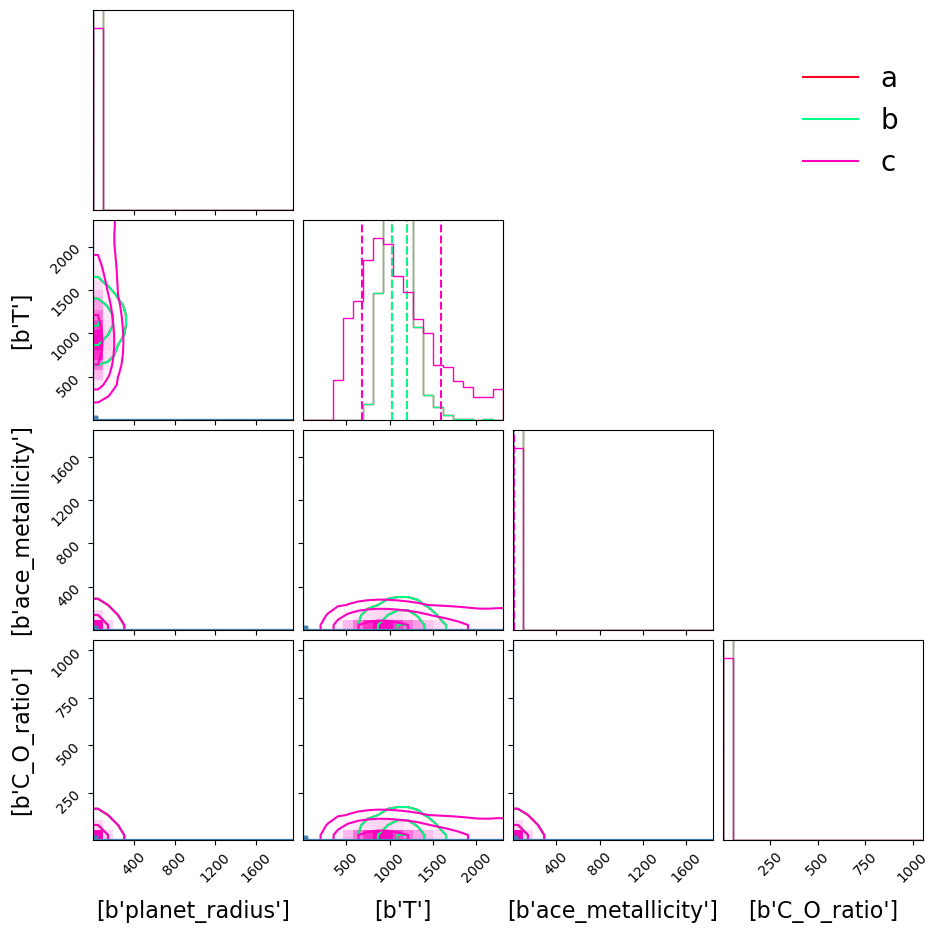

In [45]:
def get_evidence(hdf5file=None):
    if hdf5file is None:
        pass

    if isinstance(hdf5file, (str, Path)):
        res = h5py.File(hdf5file, 'r')
    elif isinstance(hdf5file, h5py.File):
        res = hdf5file
    else:
        raise NotImplementedError

    evidence = deepcopy(res['Output']['Solutions']['solution0']['Statistics']['local log-evidence'][()])
    res.close()
    return evidence


CORNER_KWARGS = dict(
    smooth=0.9,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=16),
    quantiles=[0.16, 0.84],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    plot_density=True,
    plot_datapoints=True,
    fill_contours=False,
    show_titles=False,
    max_n_ticks=5,
    quiet=True,
)

import matplotlib.lines as mlines


def overlaid_corner(samples_list, sample_labels):
    """Plots multiple corners on top of each other"""
    # get some constants
    n = len(samples_list)
    _, ndim = samples_list[0].shape
    max_len = max([len(s) for s in samples_list])
    cmap = plt.cm.get_cmap('gist_rainbow', n)
    colors = [cmap(i) for i in range(n)]

    plot_range = []
    for dim in range(ndim):
        plot_range.append(
            [
                min([min(samples_list[i].T[dim]) for i in range(n)]),
                max([max(samples_list[i].T[dim]) for i in range(n)]),
            ]
        )

    CORNER_KWARGS.update(range=plot_range)

    fig = corner(
        samples_list[0],
        color=colors[0],
        **CORNER_KWARGS
    )

    for idx in range(1, n):
        fig = corner(
            samples_list[idx],
            fig=fig,
            weights=get_normalisation_weight(len(samples_list[idx]), max_len),
            color=colors[idx],
            **CORNER_KWARGS
        )

    plt.legend(
        handles=[
            mlines.Line2D([], [], color=colors[i], label=sample_labels[i])
            for i in range(n)
        ],
        fontsize=20, frameon=False,
        bbox_to_anchor=(1, ndim), loc="upper right"
    )
    plt.savefig("corner.png")
    plt.close()


def get_normalisation_weight(len_current_samples, len_of_longest_samples):
    return np.ones(len_current_samples) * (len_of_longest_samples / len_current_samples)


def overplot_corners(hdf5file=None):
    res = hdf5file

    n = len(res)

    print(res[0]['Output']['Solutions']['solution0']['tracedata'][()].shape)

    _, ndim = res[0]['Output']['Solutions']['solution0']['tracedata'][()].shape

    # TODO:
    ndim = 4

    max_len = max([len(s['Output']['Solutions']['solution0']['tracedata'][()]) for s in res])
    cmap = plt.cm.get_cmap('gist_rainbow', n)
    colors = [cmap(i) for i in range(n)]

    plot_range = []
    for dim in range(ndim):
        plot_range.append(
            [
                min([min(res[i]['Output']['Solutions']['solution0']['tracedata'][()][dim]) for i in range(n)]),
                max([max(res[i]['Output']['Solutions']['solution0']['tracedata'][()][dim]) for i in range(n)]),
            ]
        )

    CORNER_KWARGS.update(range=plot_range)

    fig = corner(
        res[0]['Output']['Solutions']['solution0']['tracedata'][()][:, :ndim],
        color=colors[0],
        labels=res[0]['Optimizer']['fit_parameter_names'][()][:ndim],
        truths=list(res[0]['Output']['Solutions']['solution0']['fit_params'])[:ndim],
        **CORNER_KWARGS
    )

    labels = ["a", "b", "c"]

    for idx, result in zip(range(1, n), res):
        final_para = list(result['Output']['Solutions']['solution0']['fit_params'])[:ndim]
        traces = result['Output']['Solutions']['solution0']['tracedata'][()][:, :ndim]

        fig = corner(
            traces,
            fig=fig,
            # weights=get_normalisation_weight(len(traces), max_len),
            color=colors[idx],
            truths=final_para,
            **CORNER_KWARGS
        )

    plt.legend(
        handles=[
            mlines.Line2D([], [], color=colors[i], label=labels[i])
            for i in range(n)
        ],
        fontsize=20, frameon=False,
        bbox_to_anchor=(1, ndim), loc="upper right"
    )
    # plt.savefig("corner.png")
    # plt.close()

    # for res in results:
    #
    #     fit_para = res['Optimizer']['fit_parameter_names'][()]
    #     final_para = res['Output']['Solutions']['solution0']['fit_params']
    #     traces = res['Output']['Solutions']['solution0']['tracedata'][()]


overplot_corners(results)
plt.show()

In [47]:
for name, h5obj in results[0].items():
    if isinstance(h5obj, h5py.Group):
        print(name, 'is a Group')
    elif isinstance(h5obj, h5py.Dataset):
        print(name, 'is a Dataset')
        # return a np.array using dataset object:
        arr1 = h5obj[:]
        # return a np.array using dataset name:
        arr2 = results[0][name][:]
        # compare arr1 to arr2 (should always return True):
        print(np.array_equal(arr1, arr2))


def print_attrs(name, obj):
    shift = name.count('/') * '    '
    print(shift + name)
    for key, val in obj.attrs.items():
        print(shift + '    ' + f"{key}: {val}")


results[0].visititems(print_attrs)

ModelParameters is a Group
Observed is a Group
Optimizer is a Group
Output is a Group
ModelParameters
    ModelParameters/Chemistry
        ModelParameters/Chemistry/ace_co_ratio
        ModelParameters/Chemistry/ace_metallicity
        ModelParameters/Chemistry/active_gases
        ModelParameters/Chemistry/chemistry_type
        ModelParameters/Chemistry/inactive_gases
        ModelParameters/Chemistry/spec_file
        ModelParameters/Chemistry/therm_file
    ModelParameters/Contributions
        ModelParameters/Contributions/AbsorptionContribution
        ModelParameters/Contributions/CIAContribution
            ModelParameters/Contributions/CIAContribution/cia_pairs
        ModelParameters/Contributions/RayleighContribution
        ModelParameters/Contributions/SimpleCloudsContribution
            ModelParameters/Contributions/SimpleCloudsContribution/clouds_pressure
    ModelParameters/Planet
        ModelParameters/Planet/albedo
        ModelParameters/Planet/impact_param
      

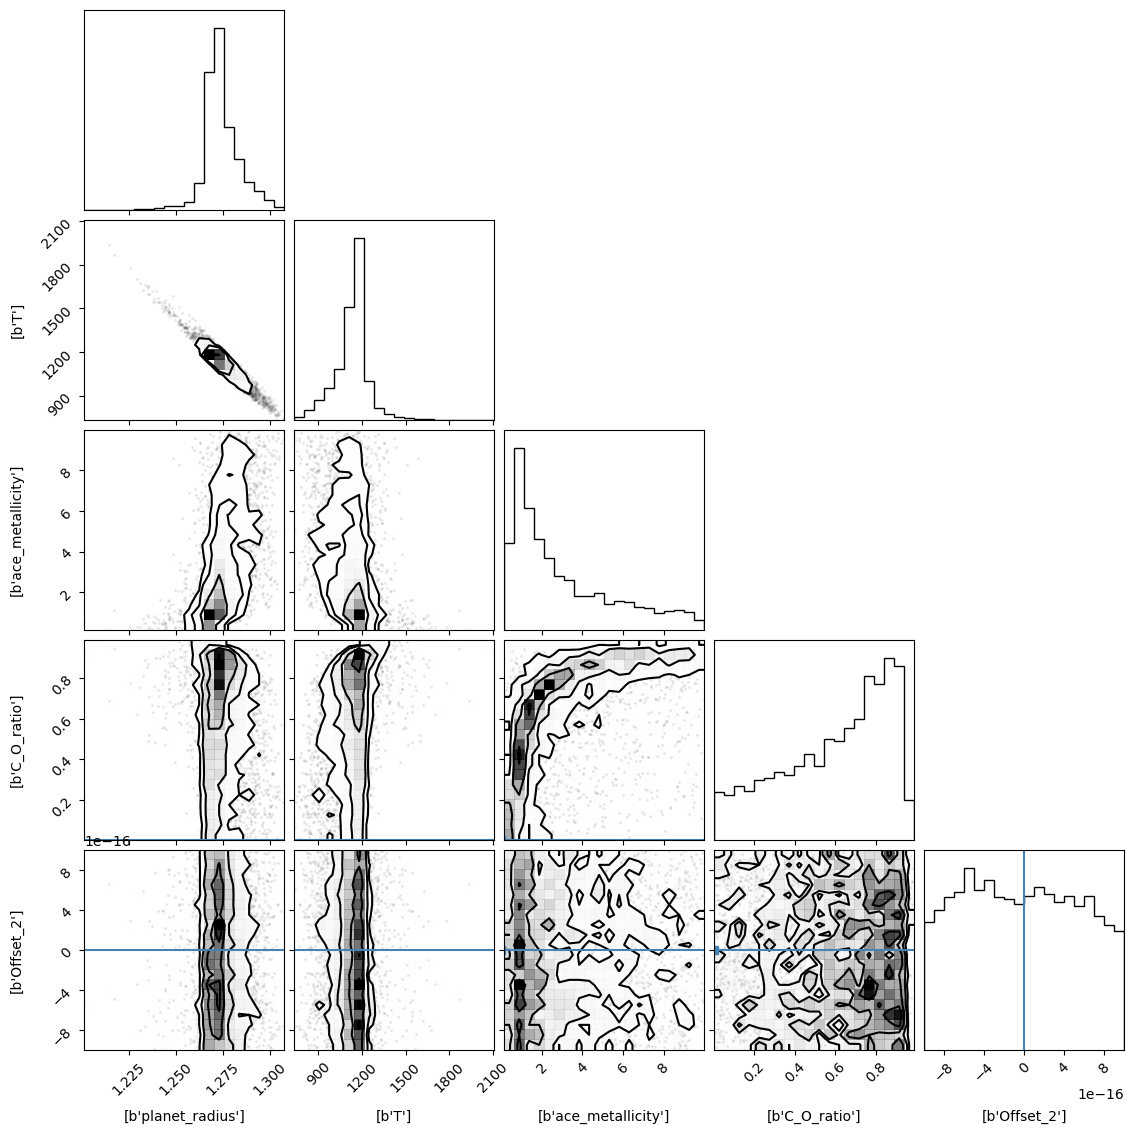

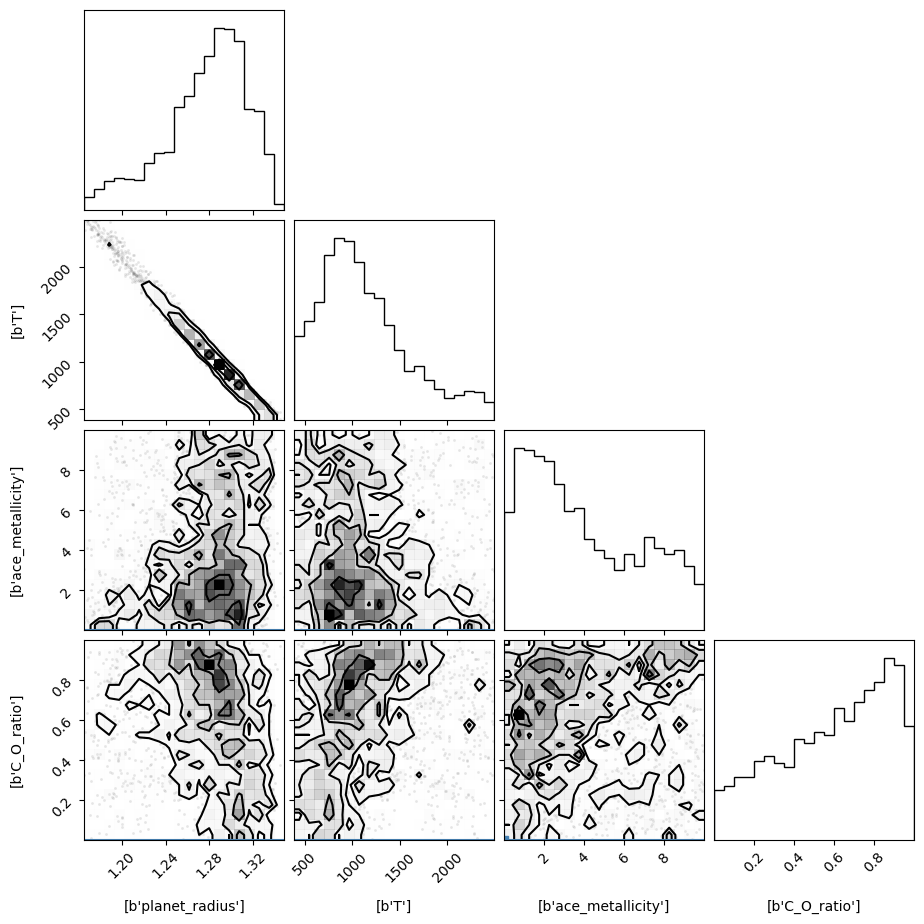

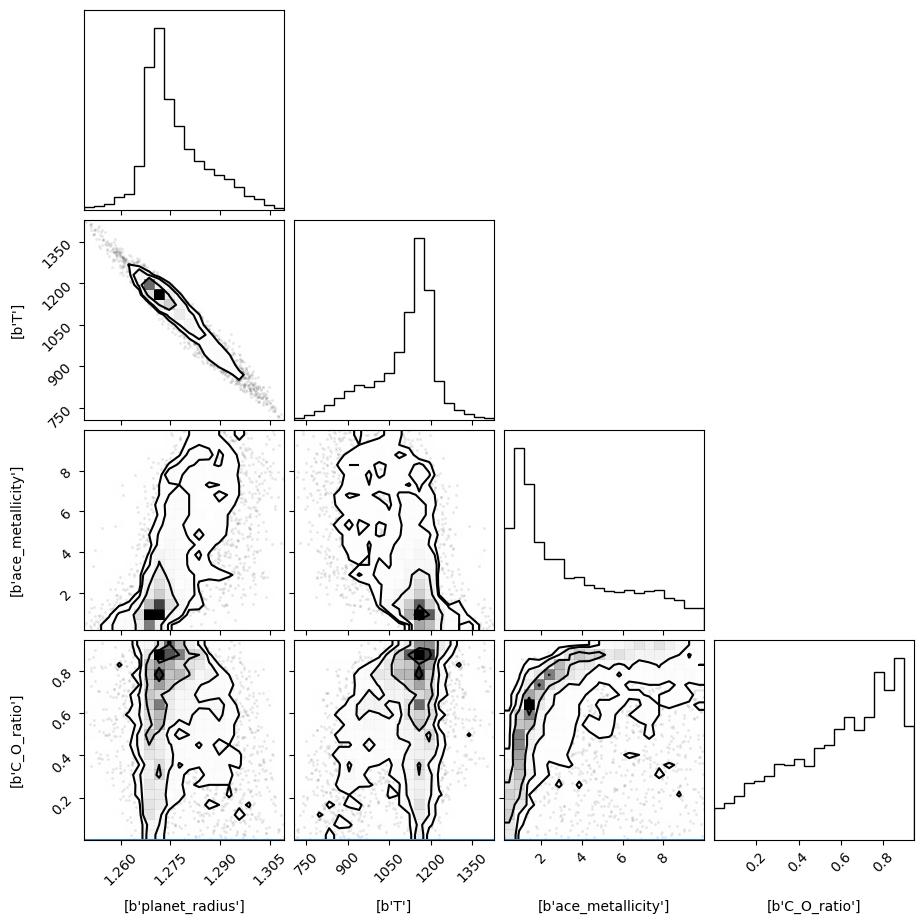

In [51]:
for res in results:
    fit_para = np.array(res['Optimizer']['fit_parameter_names'][()])
    final_para = np.array(res['Output']['Solutions']['solution0']['fit_params'])

    traces = np.array(res['Output']['Solutions']['solution0']['tracedata'][()])

    corner(
        data=traces,  # [:, burn_in:],
        labels=fit_para,
        truths=final_para,
        quiet=True,
    )

TypeError: Accessing a group is done with bytes or str, not <class 'int'>

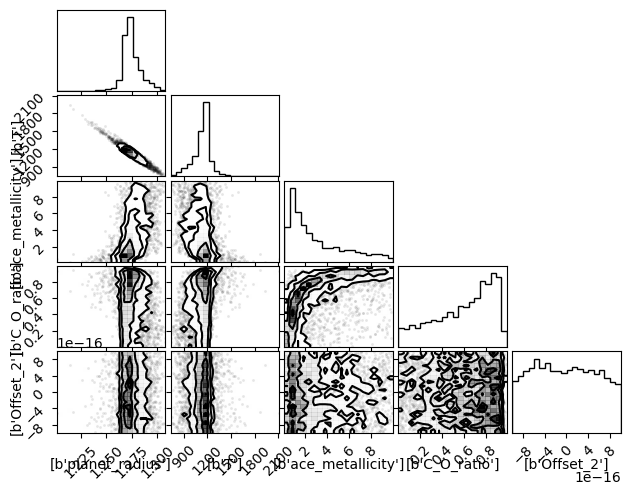

In [30]:



def divergence_models(model_files, burn_in=0.1):
    fig = plt.figure(num="divergence_corner")  #, constrained_layout=True)

    if not isinstance(burn_in, int):
        burn_in = 100

    colors = ["red", "blue", "green"]
    for i, file in enumerate(model_files):

        if isinstance(file, (str, Path)):
            res = h5py.File(file, 'r')
        elif isinstance(file, h5py.File):
            res = file
        else:
            raise NotImplementedError

        fit_para = res['Optimizer']['fit_parameter_names'][()]
        final_para = res['Output']['Solutions']['solution0']['fit_params']

        traces = res['Output']['Solutions']['solution0']['tracedata'][()]

        # if not isinstance(burn_in, int):
        #     burn_in = int(burn_in * len(traces))

        fig = corner(
            data=traces,  # [:, burn_in:],
            labels=fit_para,
            truths=final_para,
            fig=fig,
            quiet=True,
        )

    # filename = Path(model_files[0]).parent / "divergence_corner.png"
    # plt.savefig(filename, dpi=300)


divergence_models(results)

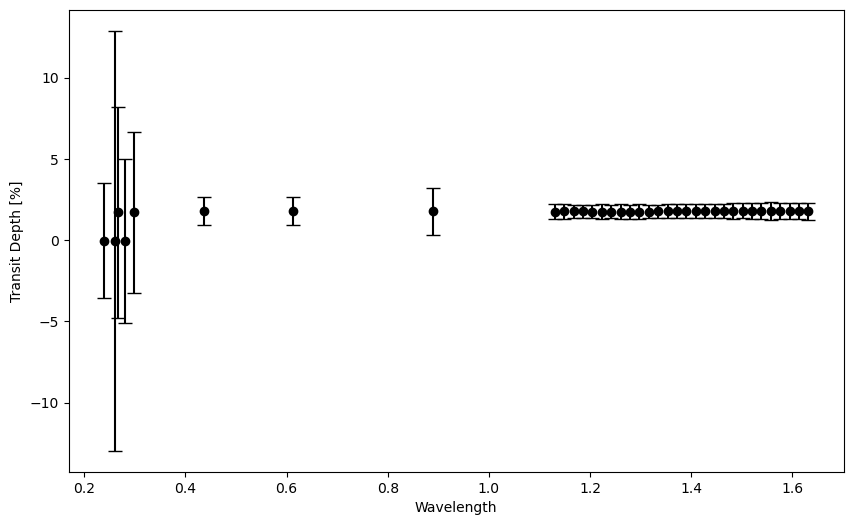

In [2]:
res = h5py.File(
    '/home/lukasw/Documents/git/compla/data/synthetic_spectra/WASP-121b/WASP-121b_HST_instrument(STIS_WFC3)_spectral_element(G141_G430L)_aperture(52X2_GRISM256)_source(Evans+2016,TM0_Sing+2019,TM1)/WASP-121b_HST_instrument(STIS_WFC3)_spectral_element(G141_G430L)_aperture(52X2_GRISM256)_source(Evans+2016,TM0_Sing+2019,TM1)_time-2023-04-24-10-33-16_output.hdf5',
    'r')  # replace this with one of your retrievals

factor = 1e2

plt.figure(figsize=(10, 6))
plt.errorbar(res['Observed']['wlgrid'][()], res['Observed']['spectrum'][()] * factor,
             yerr=res['Observed']['errorbars'][()] * factor,
             fmt='o', c='k', capsize=5)
# plt.xlim(0.85,1.7)
# plt.ylim(2.01,2.17)
plt.xlabel('Wavelength')
plt.ylabel('Transit Depth [%]')
plt.show()

In [17]:
# print(res.keys())
# print(res["ModelParameters"].keys())
# print(res["ModelParameters"].keys())
# print(res["ModelParameters"].keys())
# print(res["ModelParameters"].keys())
# print(res.walk())

def print_attrs(name, obj):
    print(name)
    # for key, val in obj.attrs.iteritems():
    #     print(key)


res.visititems(print_attrs)



ModelParameters
ModelParameters/Chemistry
ModelParameters/Chemistry/active_gases
ModelParameters/Chemistry/chemistry_type
ModelParameters/Chemistry/inactive_gases
ModelParameters/Contributions
ModelParameters/Contributions/AbsorptionContribution
ModelParameters/Contributions/CIAContribution
ModelParameters/Contributions/CIAContribution/cia_pairs
ModelParameters/Contributions/HydrogenIon
ModelParameters/Contributions/HydrogenIon/e-
ModelParameters/Contributions/HydrogenIon/hydrogen
ModelParameters/Contributions/RayleighContribution
ModelParameters/Contributions/SimpleCloudsContribution
ModelParameters/Contributions/SimpleCloudsContribution/clouds_pressure
ModelParameters/Planet
ModelParameters/Planet/albedo
ModelParameters/Planet/impact_param
ModelParameters/Planet/mass_kg
ModelParameters/Planet/orbital_period
ModelParameters/Planet/planet_distance
ModelParameters/Planet/planet_mass
ModelParameters/Planet/planet_radius
ModelParameters/Planet/planet_type
ModelParameters/Planet/radius_m
M

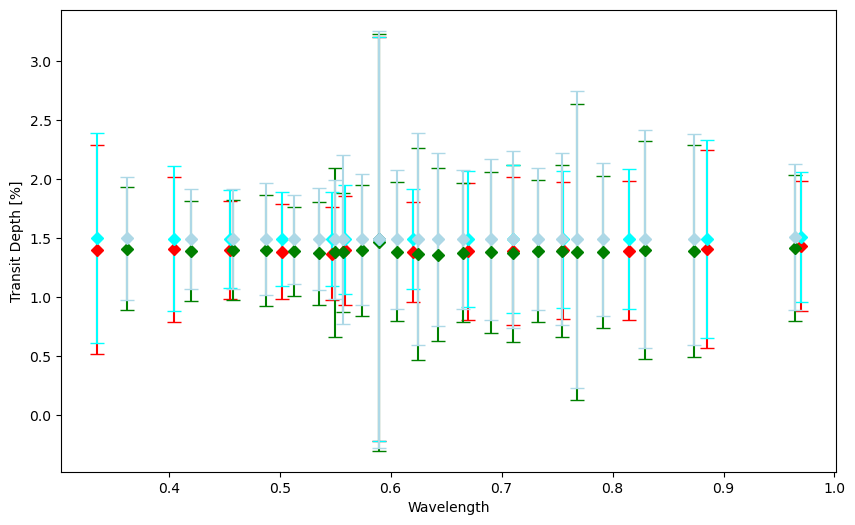

In [8]:
from pathlib import Path

WDIR = Path().cwd().parent

path_list = [
    str(WDIR / "data/taurex_lightcurves_LW" / "HAT-P-1-b_HST_STIS_G430L_52X2_Nikolov+2014.txt"),
    str(WDIR / "data/taurex_lightcurves_LW" / "HAT-P-1-b_HST_STIS_G430L_52X2_Sing+2016.txt"),
    str(WDIR / "data/synthetic_spectra/HAT-P-1b" / "synthetic_HAT-P-1-b_HST_STIS_G430L_52X2_Nikolov+2014_transmission_spectrum_0.txt"),
    str(WDIR / "data/synthetic_spectra/HAT-P-1b" / "synthetic_HAT-P-1-b_HST_STIS_G430L_52X2_Sing+2016_transmission_spectrum_1.txt"),
]

# syn_spectrum = np.loadtxt(str(WDIR / f"data/synthetic_spectra/HAT-P-1b/synthetic_HAT-P-1b_transmission_spectrum_1.txt")).T
# real_spectrum1 = np.loadtxt(str(WDIR / "data/taurex_lightcurves_LW/HAT-P-1-b_HST_STIS_G430L_52X2_Sing+2016.txt")).T
# real_spectrum2 = np.loadtxt(str(WDIR / "data/SpectraBE/HAT-P-1b_G141.txt")).T

factor = 1e2

plt.figure(figsize=(10, 6))

for spectrum, c in zip(path_list, ["r", "g", "cyan", "lightblue"]):
    spectrum = np.loadtxt(spectrum).T
    plt.errorbar(spectrum[0], spectrum[1] * factor,
                 yerr=spectrum[2] * factor,
                 fmt='D', c=c, capsize=5)

# plt.xlim(0.85,1.7)
# plt.ylim(2.01,2.17)
plt.xlabel('Wavelength')
plt.ylabel('Transit Depth [%]')
plt.show()

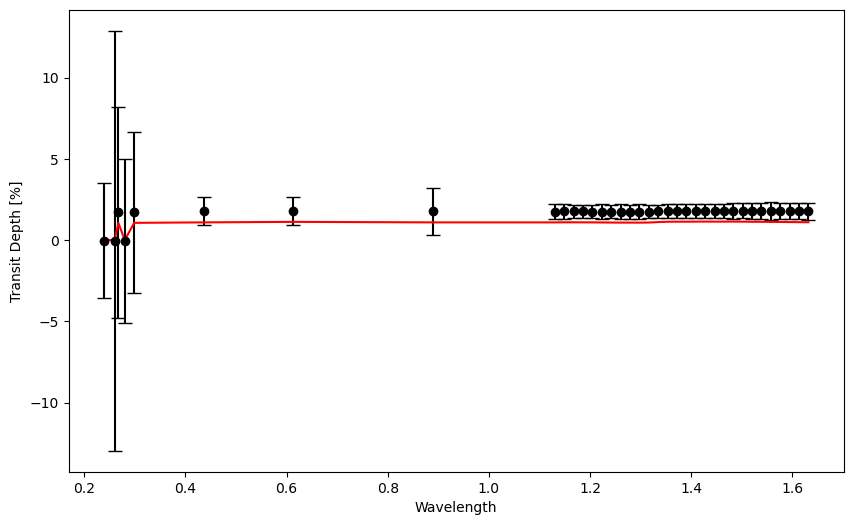

In [3]:
res_spec = res['Output']['Solutions']['solution0']['Spectra']

"""You can plot the best-fit spectrum at the binned resolution but it looks ugly"""

plt.figure(figsize=(10, 6))
plt.errorbar(res['Observed']['wlgrid'][()], res['Observed']['spectrum'][()] * factor,
             yerr=res['Observed']['errorbars'][()] * factor,
             fmt='o', c='k', capsize=5)
plt.plot(res_spec['binned_wlgrid'][()], res_spec['binned_spectrum'][()] * factor, c='r')
# plt.xlim(0.85, 1.7)
# plt.ylim(2.01, 2.17)
plt.xlabel('Wavelength')
plt.ylabel('Transit Depth [%]')
plt.show()


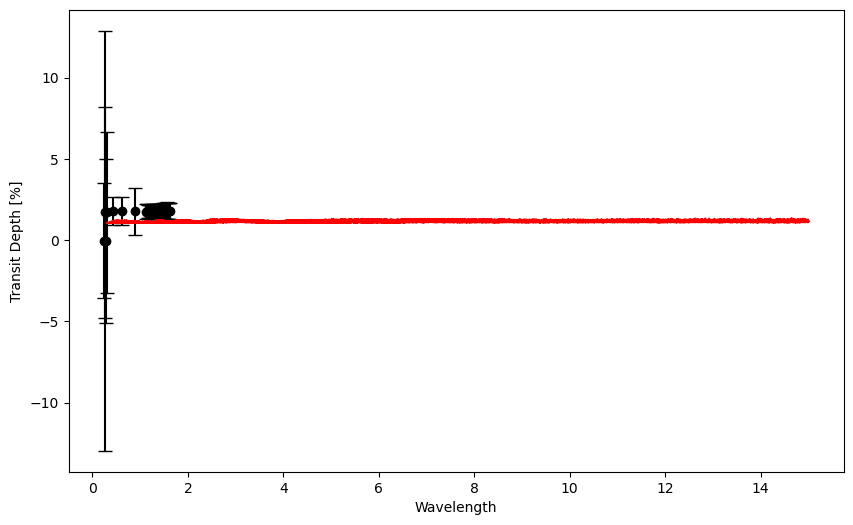

In [5]:
"""Same for the native...."""

plt.figure(figsize=(10, 6))
plt.errorbar(res['Observed']['wlgrid'][()], res['Observed']['spectrum'][()] * factor,
             yerr=res['Observed']['errorbars'][()] * factor,
             fmt='o', c='k', capsize=5)
plt.plot(res_spec['native_wlgrid'][()], res_spec['native_spectrum'][()] * factor, c='r')
# plt.xlim(0.85,1.7)
# plt.ylim(2.01,2.17)
plt.xlabel('Wavelength')
plt.ylabel('Transit Depth [%]')
plt.show()

Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


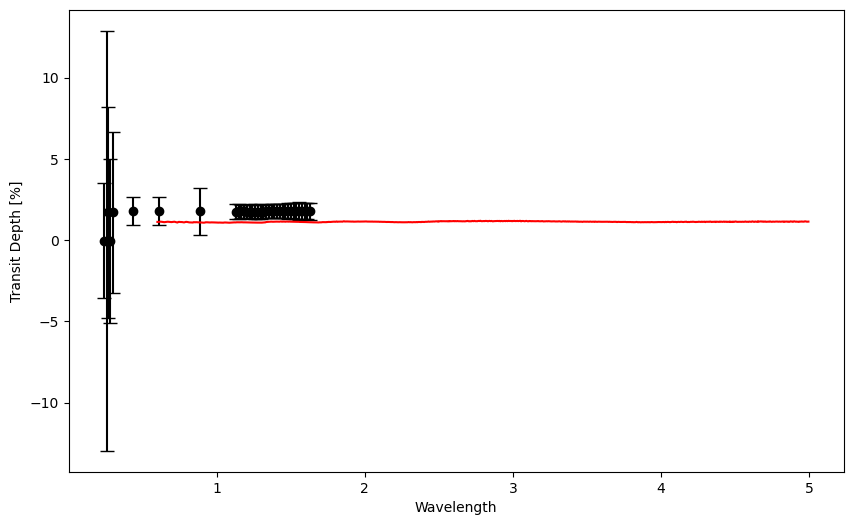

In [6]:
from taurex.binning.fluxbinner import FluxBinner
from taurex.util.util import wnwidth_to_wlwidth
import pandas as pd


def bin_spectrum(low_res, high_res):
    transmission_spectra = high_res.sort_values(by='wavelength')
    low_res = low_res.sort_values(by='wavelength')
    low_res = low_res.reset_index(drop=True)

    binner = FluxBinner(low_res['wavelength'].values)

    _, binned_transit_depth, _, _ = binner.bindown(transmission_spectra['wavelength'].values,
                                                   transmission_spectra['depth'].values)

    return np.array(binned_transit_depth)


"""So let's bin it tro something in-between"""

hr = pd.DataFrame(res_spec['native_wlgrid'][()], columns=['wavelength'])
hr['depth'] = res_spec['native_spectrum'][()]

bd = 0.005
lr = pd.DataFrame(np.arange(0.6, 5, bd), columns=['wavelength'])
lr['depth'] = bin_spectrum(lr.copy(), hr)

plt.figure(figsize=(10, 6))
plt.errorbar(res['Observed']['wlgrid'][()], res['Observed']['spectrum'][()] * factor,
             yerr=res['Observed']['errorbars'][()] * factor,
             fmt='o', c='k', capsize=5)
plt.plot(lr['wavelength'], lr['depth'] * factor, c='r')
# plt.xlim(0.85,1.7)
# plt.ylim(2.01,2.17)
plt.xlabel('Wavelength')
plt.ylabel('Transit Depth [%]')
plt.show()

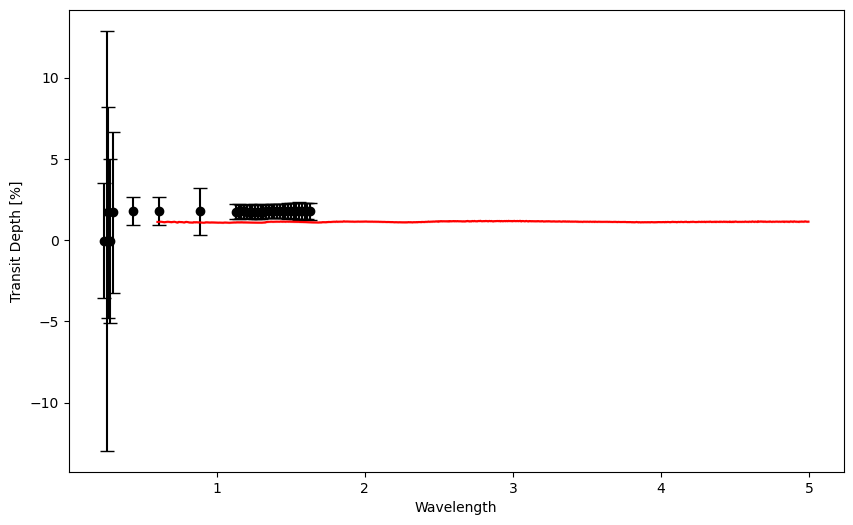

In [7]:
"""Might also want to plot 1 sigma uncertainities on the best-fit model..."""

hr_plus_std = hr.copy()
hr_plus_std['depth'] = res_spec['native_spectrum'][()] + res_spec['native_std'][()]

hr_minus_std = hr.copy()
hr_minus_std['depth'] = res_spec['native_spectrum'][()] - res_spec['native_std'][()]

lr['depth_m_std'] = bin_spectrum(lr.copy(), hr_minus_std)
lr['depth_p_std'] = bin_spectrum(lr.copy(), hr_plus_std)

plt.figure(figsize=(10, 6))
plt.errorbar(res['Observed']['wlgrid'][()], res['Observed']['spectrum'][()] * factor,
             yerr=res['Observed']['errorbars'][()] * factor,
             fmt='o', c='k', capsize=5)
plt.plot(lr['wavelength'], lr['depth'] * factor, c='r')
plt.fill_between(lr['wavelength'], lr['depth_m_std'] * factor, lr['depth_p_std'] * factor, color='r', alpha=0.3)
# plt.xlim(0.85,1.7)
# plt.ylim(2.01,2.17)
plt.xlabel('Wavelength')
plt.ylabel('Transit Depth [%]')
plt.show()

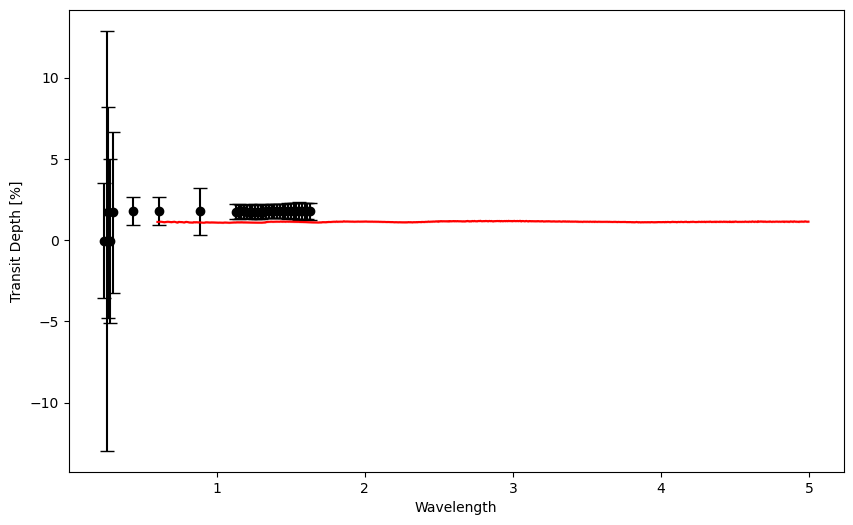

In [9]:
"""Can also be interesting to project to longer wavelengths. In this case, the big uncertainty at ~4.5
micron is because the retrieval could not well constrain carbon-bearing species (e.g., CO2)"""

plt.figure(figsize=(10, 6))
plt.errorbar(res['Observed']['wlgrid'][()], res['Observed']['spectrum'][()] * factor,
             yerr=res['Observed']['errorbars'][()] * factor,
             fmt='o', c='k', capsize=5)
plt.plot(lr['wavelength'], lr['depth'] * factor, c='r')
plt.fill_between(lr['wavelength'], lr['depth_m_std'] * factor, lr['depth_p_std'] * factor, color='r', alpha=0.3)
# plt.xlim(0.85,5.)
# plt.ylim(2.01,2.17)
plt.xlabel('Wavelength')
plt.ylabel('Transit Depth [%]')
plt.show()

In [19]:
#Get the Bayesian evidence, ln(E)
evidence = res['Output']['Solutions']['solution0']['Statistics']['local log-evidence'][()]
evidence

106.51690675182053

In [20]:
import scipy as sp
from scipy.special import *
from numpy import interp

"""A function to compare the Bayesian evidence and convert the difference to sigma"""


def sigma(lnz1, lnz2):
    lnB = lnz1 - lnz2
    logp = np.arange(-100.00, 0.00, .1)  #reverse order
    logp = logp[::-1]  # original order
    P = 10.0 ** logp
    Barr = -1. / (np.exp(1) * P * np.log(P))

    sigma = np.arange(0.1, 100.10, .01)
    p_p = sp.special.erfc(sigma / np.sqrt(2.0))
    B = np.exp(lnB)
    pvalue = 10.0 ** interp(np.log10(B), np.log10(Barr), np.log10(P))
    sig = interp(pvalue, p_p[::-1], sigma[::-1])

    return sig


evidence_2 = 252

sigma(evidence, evidence_2)

0.26069518724310603

[[b'planet_radius']
 [b'T_surface']
 [b'T_top']
 [b'log_P_top']
 [b'log_P_point1']
 [b'log_P_point2']
 [b'T_point1']
 [b'T_point2']
 [b'log_metallicity']
 [b'C_O_ratio']
 [b'log_clouds_pressure']
 [b'Offset_1']]


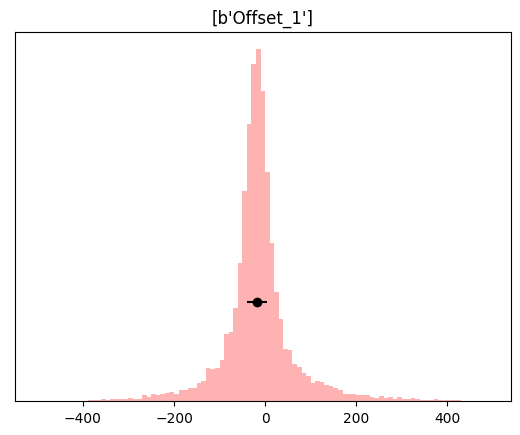

In [118]:
"""output file also contrains all the traces so you can replot the posteriors"""

fit_para = res['Optimizer']['fit_parameter_names'][()]
final_para = res['Output']['Solutions']['solution0']['fit_params']

print(fit_para)  # list of fitted parameters

traces = res['Output']['Solutions']['solution0']['tracedata'][()]

#lets plot the offset between G102 and G141
idx = 11
plt.figure()
plt.hist(traces[:, idx] * 1e6, bins=np.arange(-500, 500, 10), color='r', alpha=0.3)
plt.errorbar(final_para['Offset_1']['value'][()] * 1e6, 500,
             xerr=[[final_para['Offset_1']['sigma_m'][()] * 1e6], [final_para['Offset_1']['sigma_p'][()] * 1e6]],
             fmt='o', c='k')
plt.title(fit_para[idx])
plt.yticks([])
plt.show()